In [2]:
import json
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
# DoSRandom_0709 = 5090093, DoSRandom_1416 = 1400517
BSM_SIZE = 5090093
N_FEATURES = 14

In [107]:
root_dir = 'DoSRandom_0709/'


filenames = glob.glob(root_dir + '**/traceJSON*.json', recursive=True)

attacker_sender_map = {}

for filepath in filenames:
    filename = filepath.split('/')[-1]
    _, vehicle, _, attacker = filename.split('-')[:4] # Rever definições da nomenclatura
    attacker_type = int(attacker[1:])
    vehicle_id = int(vehicle)
    attacker_sender_map[vehicle_id] = attacker_type
         
# i = 0
# for filepath in tqdm(filenames):
#     f = open(filepath)
#     for line in f:
#         i += 1
# print(i)
    
bsm = np.memmap('bsmdos.memmap', dtype='float32', mode='w+', shape=(BSM_SIZE, N_FEATURES))
bsm_pos = 0
prev_receiver = None
for filepath in (pbar := tqdm(filenames)):
    f = open(filepath)
    receiver = int(filepath.split('/')[-1].split('-')[1])
    pbar.set_description("Vehicle ID {}".format(receiver))
    for line in f:
        data = json.loads(line)
        if data['type'] == 3:
            attack_type = attacker_sender_map.get(data['sender'], None)
            if attack_type is not None:
                out = (
                   data['messageID'],
                   data['rcvTime'],
                   data['sendTime'],
                   receiver,
                   data['sender'],
                   attack_type,
                   data['pos'][0],
                   data['pos'][1],
                   data['spd'][0],
                   data['spd'][1],
                   data['acl'][0],
                   data['acl'][1],
                   data['hed'][0],
                   data['hed'][1],
                )
                bsm[bsm_pos] = out
                bsm_pos += 1

  0%|          | 0/4068 [00:00<?, ?it/s]

In [190]:
bsm = np.memmap('bsmdos.memmap', dtype='float32', mode='r', shape=(BSM_SIZE, N_FEATURES))
df = pd.DataFrame(bsm, columns=[
    'message_id',
    'rcv_time',
    'send_time',
    'receiver',
    'sender',
    'attack_type',
    'pos_x',
    'pos_y',
    'spd_x',
    'spd_y',
    'acl_x',
    'acl_y',
    'hed_x',
    'hed_y',
]).drop_duplicates(subset='message_id')#.set_index('message_id')
df = df[df.message_id != 0]
df = df.sort_values(['sender', 'send_time']).reset_index(drop=True)
df

,message_id,rcv_time,send_time,receiver,sender,attack_type,pos_x,pos_y,spd_x,spd_y,acl_x,acl_y,hed_x,hed_y
0,30704.0,25212.603516,25212.603516,45.0,9.0,0.0,257.643921,141.896606,-2.410001,14.316096,-0.066395,0.395049,-0.163225,0.986589
1,31035.0,25213.603516,25213.603516,45.0,9.0,0.0,255.159973,156.183960,-2.566648,14.210019,0.153209,-0.847553,-0.174971,0.984574
2,31276.0,25214.603516,25214.603516,45.0,9.0,0.0,252.895309,170.462082,-2.342860,14.254301,0.036057,-0.218773,-0.159290,0.987232
3,31517.0,25215.603516,25215.603516,45.0,9.0,0.0,250.568130,184.796082,-2.352868,14.315008,0.011470,-0.069188,-0.159290,0.987232
4,31758.0,25216.603516,25216.603516,45.0,9.0,0.0,248.498978,199.129242,-2.079337,14.360960,-0.079433,0.549182,-0.140398,0.990095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618921,90376808.0,32397.587891,32397.587891,24399.0,24411.0,14.0,399.922119,1403.784302,33.610752,6.421859,1.262094,1.144848,0.484984,-0.792464
618922,90381808.0,32398.087891,32398.087891,24399.0,24411.0,14.0,1398.825806,1012.823181,1.415416,35.932575,1.418390,0.433917,0.785854,-0.707925
618923,90387352.0,32398.587891,32398.587891,24399.0,24411.0,14.0,880.237915,448.160858,36.325401,25.845148,0.587795,1.615443,-0.098634,-0.252333
618924,90392256.0,32399.087891,32399.087891,24399.0,24411.0,14.0,464.213776,1369.368774,26.715353,39.256348,0.238729,1.180224,0.940712,-0.693935


<Axes: xlabel='send_time'>

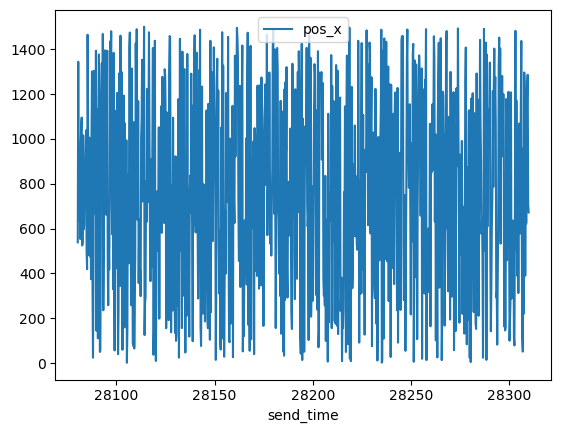

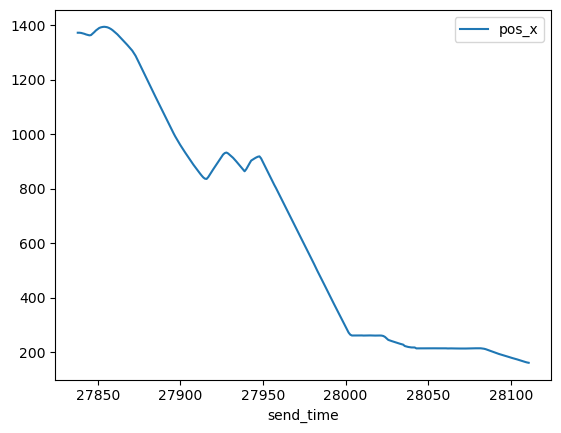

In [191]:
df[df.sender == 8571].plot(x='send_time', y='pos_x')

df[df.sender == 7779].plot(x='send_time', y='pos_x')

In [282]:
# filter for prototyping
df_s = df.copy() #[:round(df.shape[0] * 0.03)]

split = round(df_s.shape[0] * 0.5)

train = df_s[:split]
filtered_train = train[train.attack_type < 10].drop(columns=['attack_type'])
filtered_train.to_csv('out_veremi_dos/train.csv')

train = train.drop(columns=['attack_type'])
train.to_csv('out_veremi_dos/train_no_filter.csv')

test = df_s[split:].drop(columns=['attack_type'])
test.to_csv('out_veremi_dos/test.csv')

y = (df_s['attack_type'] >= 10)[split:].astype(int)

labels = pd.concat([y] * len(test.columns), ignore_index=True, axis=1)
labels.to_csv('out_veremi_dos/labels.csv')

# df_test_split = df_s[split:]

# for i in range(10, 20):
#     test = df_test_split[df_test_split.attack_type.isin((i, 0))].copy()
    
#     y = (test.attack_type == i).astype(int)
#     test.drop(columns=['attack_type'], inplace=True)
    
#     labels = pd.concat([y] * len(test.columns), ignore_index=True, axis=1)

#     test.to_csv(f'out_veremi_dos/test_{i}.csv')
#     labels.to_csv(f'out_veremi_dos/labels_{i}.csv')

<Axes: >

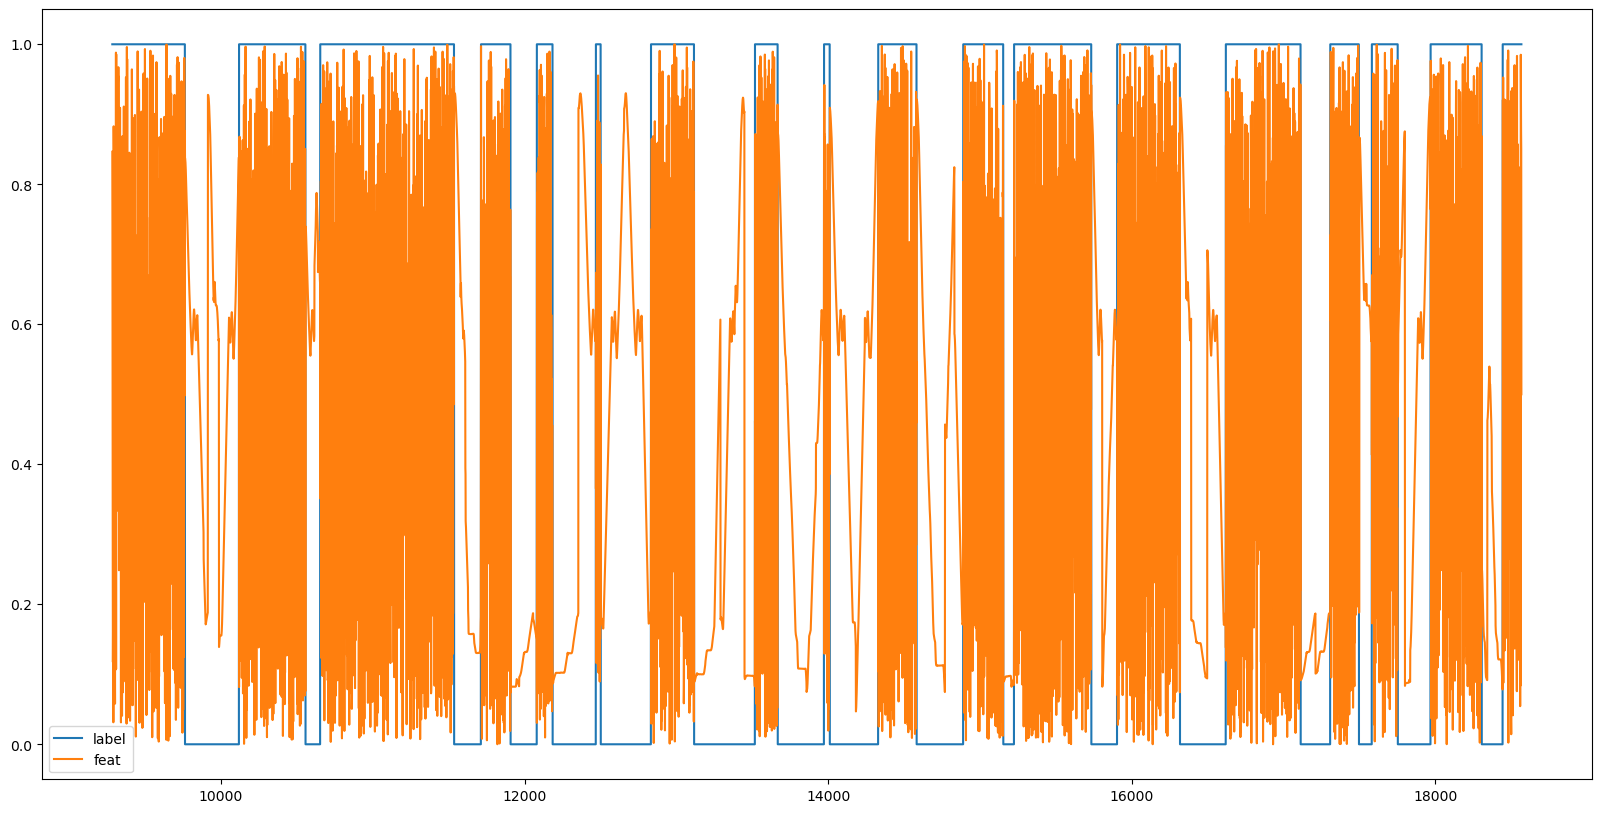

In [279]:
feat = test.pos_x

feat_norm = (feat - feat.min()) / (feat.max() - feat.min())

pd.DataFrame({ 'label': labels[0], 'feat': feat_norm }).plot(figsize=(20,10))

In [ ]:
test